In [1]:
%matplotlib inline

seed_value = 100
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# Data uploading

In [2]:
#AIRPORT_ICAO = "ESGG"
AIRPORT_ICAO = "ESSA"

RT1 = False
remove_outliers = False

DATA_DIR = os.path.join("..", "..")
DATA_DIR = os.path.join(DATA_DIR, "data")
DATA_DIR = os.path.join(DATA_DIR, "Regression")

# WIF
if RT1:
    filename = AIRPORT_ICAO + "_metrics_WIF_fuel_by_hour_RT1.csv"
else:
    filename = AIRPORT_ICAO + "_metrics_WIF_fuel_by_hour_RT2.csv"
full_filename = os.path.join(DATA_DIR, filename)
metrics_WIF_fuel_by_hour_df = pd.read_csv(full_filename, sep=' ')

#print(metrics_WIF_fuel_by_hour_df.head(1))

# TIF
if RT1:
    filename = AIRPORT_ICAO + "_metrics_TIF_fuel_by_hour_RT1.csv"
else:
    filename = AIRPORT_ICAO + "_metrics_TIF_fuel_by_hour_RT2.csv"
full_filename = os.path.join(DATA_DIR, filename)
metrics_TIF_fuel_by_hour_df = pd.read_csv(full_filename, sep=' ')

#print(metrics_TIF_fuel_by_hour_df.head(1))

## Medians of Average Additional Fuel in TMA vs TIF

                            OLS Regression Results                            
Dep. Variable:          addFuelMedian   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     208.5
Date:                Thu, 15 Sep 2022   Prob (F-statistic):           5.17e-07
Time:                        16:49:47   Log-Likelihood:                -27.922
No. Observations:                  10   AIC:                             59.84
Df Residuals:                       8   BIC:                             60.45
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.7215      3.015     12.178      0.0

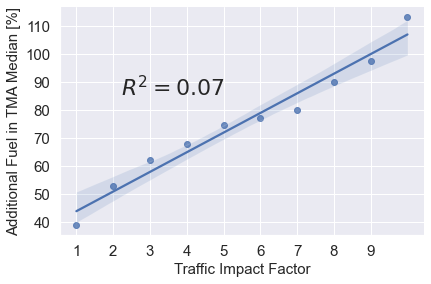

In [3]:
df = metrics_TIF_fuel_by_hour_df.copy()

df = df[df['numberOfFlights']>0]

if remove_outliers:
    p1 = df["addFuelPercentMean"].quantile(0.05)
    p2 = df["addFuelPercentMean"].quantile(0.95)
    df = df.loc[(df['addFuelPercentMean'] > p1) & (df['addFuelPercentMean'] < p2) ]

df.set_index(['TIF'], inplace=True)
df.sort_index(inplace=True)

#print(df.head(1))

median_df = pd.DataFrame(columns=['TIF', 'addFuelMedian'])

for idx, group in df.groupby(level='TIF'):
    
    idx_df = group['addFuelPercentMean']
    #print(len(idx_df))
    
    idx_median = np.median(idx_df)
    median_df = median_df.append({'TIF': idx, 'addFuelMedian': idx_median}, ignore_index=True)

median_df['TIF'] = median_df['TIF'].astype(float)
median_df['addFuelMedian'] = median_df['addFuelMedian'].astype(float)

sns.set(rc={'figure.figsize':(1,1)})

sns.lmplot(x='TIF',y='addFuelMedian',data=median_df,fit_reg=True, height=4, aspect=3/2);
plt.xlabel('Traffic Impact Factor', fontsize=15)
plt.ylabel('Additional Fuel in TMA Median [%]', fontsize=15)
#ticks = [i for i in range(1, 11)]
ticks = [i for i in range(1, 10)]
plt.xticks(ticks, fontsize=15)
plt.yticks(fontsize=15)
plt.text(2.2, 85, '$R^2 = 0.07$', fontsize = 22)

#statsmodel:
X_df = median_df[['TIF']]
y_df = median_df[['addFuelMedian']]

X2 = sm.add_constant(X_df.values)
est = sm.OLS(y_df, X2)
est2 = est.fit()
print(est2.summary())

# RT2 
# with outliers - ESGG: 0.07, ESSA: 0.96

x = X_df['TIF'].values.tolist()
y = y_df['addFuelMedian'].values.tolist()

# calculate pearnon's correlation
pearsonr, p = stats.pearsonr(x,y) 
print(pearsonr, p)

# calculate spearman's correlation
spearmanr, p = stats.spearmanr(x, y)
print(spearmanr, p)

## Medians of Average Additional Fuel in TMA vs WIF

                            OLS Regression Results                            
Dep. Variable:          addFuelMedian   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     5.721
Date:                Thu, 15 Sep 2022   Prob (F-statistic):             0.0539
Time:                        16:51:21   Log-Likelihood:                -22.655
No. Observations:                   8   AIC:                             49.31
Df Residuals:                       6   BIC:                             49.47
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.6285      3.696     12.887      0.0

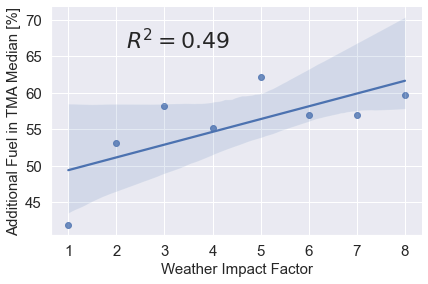

In [6]:
df = metrics_WIF_fuel_by_hour_df.copy()
df.dropna(inplace=True)
df = df[df['numberOfFlights']>0]

if remove_outliers:
    p1 = df["addFuelPercentMean"].quantile(0.05)
    p2 = df["addFuelPercentMean"].quantile(0.95)
    df = df.loc[(df['addFuelPercentMean'] > p1) & (df['addFuelPercentMean'] < p2) ]

df.set_index(['WIF'], inplace=True)
df.sort_index(inplace=True)

median_df = pd.DataFrame(columns=['WIF', 'addFuelMedian'])

for idx, group in df.groupby(level='WIF'):
    
    idx_df = group['addFuelPercentMean']

    idx_median = np.median(idx_df)
            
    median_df = median_df.append({'WIF': idx, 'addFuelMedian': idx_median}, ignore_index=True)

median_df['WIF'] = median_df['WIF'].astype(float)
median_df['addFuelMedian'] = median_df['addFuelMedian'].astype(float)

sns.set(rc={'figure.figsize':(1,1)})

sns.lmplot(x='WIF',y='addFuelMedian',data=median_df,fit_reg=True, height=4, aspect=3/2);
plt.xlabel('Weather Impact Factor', fontsize=15)
plt.ylabel('Additional Fuel in TMA Median [%]', fontsize=15)
#ticks = [i for i in range(1, 10)]
ticks = [i for i in range(1, 9)]
plt.xticks(ticks, fontsize=15)
plt.yticks(fontsize=15)
plt.text(2.2, 66, '$R^2 = 0.49$', fontsize = 22)
#plt.text(2.2, 155, '$R^2 = 0.46$', fontsize = 22)

#statsmodel:
X_df = median_df[['WIF']]
y_df = median_df[['addFuelMedian']]

X2 = sm.add_constant(X_df.values)
est = sm.OLS(y_df, X2)
est2 = est.fit()
print(est2.summary()) 

# RT2
# with outliers - ESGG: 0.46 ESSA: 0.49

x = X_df['WIF'].values.tolist()
y = y_df['addFuelMedian'].values.tolist()

# calculate pearnon's correlation
pearsonr, p = stats.pearsonr(x,y) 
print(pearsonr, p)

# calculate spearman's correlation
spearmanr, p = stats.spearmanr(x, y)
print(spearmanr, p)